# Lab Practice: Online Learning

In [1]:
import pandas as pd

# Batch Libraries (Scikit-Learn)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Online Libraries (River)
from river import compose, tree, metrics, preprocessing

# Utilities
from lab1_utils import *

# Configuration
DATA_DIR = 'data/'

## Data loading and target preparation

In [2]:
# Load dataset
file_path = DATA_DIR + 'spy.us.txt'
df = pd.read_csv(file_path)

# Delete 'OpenInt' column (always 0 value)
if 'OpenInt' in df.columns:
    df = df.drop(columns=['OpenInt'])
    print("'OpenInt' column deleted successfully")

print(f"Initial number of rows: {len(df)}")

# Delete rows with missing values
df_cleaned = df.dropna()

print(f"Final columns: {df_cleaned.columns.tolist()}")
print(f"Final number of rows: {len(df_cleaned)}")

# Save cleaned dataset
df_cleaned.to_csv(DATA_DIR + 'spy_cleaned.csv', index=False)

'OpenInt' column deleted successfully
Initial number of rows: 3201
Final columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
Final number of rows: 3201


In [3]:
# Load cleaned dataset
df = pd.read_csv(DATA_DIR + 'spy_cleaned.csv')

# Create the target: the 'High' 5 records ahead
# shift(-5) moves the values up by 5 positions.
# We are now predicting the value 5 days into the future to avoid naive correlation.
df['Target_High'] = df['High'].shift(-5)

# The last 5 rows do not have a "5th day future," so they become null (NaN)
df = df.dropna(subset=['Target_High'])

# Verify that Target_High is indeed the next day's High
print("\nFirst rows of the transformed dataset:")
df[['Date', 'High', 'Target_High']].head(21)


First rows of the transformed dataset:


,Date,High,Target_High
0,2005-02-25,106.00,107.01
1,2005-02-28,105.68,107.38
2,2005-03-01,105.87,107.15
3,2005-03-02,106.22,106.52
4,2005-03-03,106.20,105.85
5,2005-03-04,107.01,106.04
6,2005-03-07,107.38,105.56
7,2005-03-08,107.15,105.82
8,2005-03-09,106.52,104.44
9,2005-03-10,105.85,104.31


## Batch Learning

### Feature extraction and data splitting

In [4]:
# Data Splitting (Temporal Split - NO SHUFFLE): 70% training, 15% validation, and 15% test
n = len(df)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

print(f"Total samples: {n}")

# Generate features and target for the entire dataset (train + val + test) to ensure we have the necessary history for feature generation
# This prevents the first 20 rows of the validation or test sets from becoming NaN due to insufficient historical data
X_full, y_full = get_batch_features_and_target(df)
print(f"Full shapes: X={X_full.shape}, y={y_full.shape}")

# Data splitting based on indices making sure that the cut respects the reduced dataframe after feature generation
X_train = X_full.loc[X_full.index < train_end]
y_train = y_full.loc[y_full.index < train_end]

X_val = X_full.loc[(X_full.index >= train_end) & (X_full.index < val_end)]
y_val = y_full.loc[(y_full.index >= train_end) & (y_full.index < val_end)]

X_test = X_full.loc[X_full.index >= val_end]
y_test = y_full.loc[y_full.index >= val_end]

print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Val shapes: X={X_val.shape}, y={y_val.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test.shape}")

Total samples: 3196
Full shapes: X=(3176, 8), y=(3176,)
Train shapes: X=(2217, 8), y=(2217,)
Val shapes: X=(479, 8), y=(479,)
Test shapes: X=(480, 8), y=(480,)


In [5]:
X_train.head()

,Close,Return,Mean_return_5,Mean_return_20,Volatility_20,Open_Close_Diff,Volume,Volume_dev
20,102.19,0.001372,-0.002071,-0.001712,0.005964,-0.10,53885043,-15613298.30
21,101.51,-0.006654,-0.002686,-0.001709,0.005962,-0.54,83849903,14143833.75
22,102.96,0.014284,0.002193,-0.001252,0.006766,1.11,72199510,1613835.85
23,102.77,-0.001845,0.001667,-0.001320,0.006765,-0.20,74669192,4036712.75
24,102.30,-0.004573,0.000517,-0.001568,0.006789,-1.04,111800673,39142501.25


In [6]:
y_train.head()

20    102.67
21    103.12
22    103.62
23    103.89
24    103.85
Name: Target_High, dtype: float64

In [7]:
# Scale the data (standarization) to avoid inestability
scaler = StandardScaler()
# Obtain mean and std from the training data only to prevent data leakage
scaler.fit(X_train)

# Transfrom all sets with the obtained parameters from training set
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Shapes after scaling:")
print(f"Train shapes: X={X_train_scaled.shape}, y={y_train.shape}")
print(f"Val shapes: X={X_val_scaled.shape}, y={y_val.shape}")
print(f"Test shapes: X={X_test_scaled.shape}, y={y_test.shape}")

Shapes after scaling:
Train shapes: X=(2217, 8), y=(2217,)
Val shapes: X=(479, 8), y=(479,)
Test shapes: X=(480, 8), y=(480,)


### Model 1: RandomForest

In [8]:
# Define and train model
print("Training Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

Training Random Forest...


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
def plot_predictions(model, X_scaled, y_real, df, set_name, model_name='Model'):
    y_pred = model.predict(X_scaled)
    mae = mean_absolute_error(y_real, y_pred)
    dates = pd.to_datetime(df.loc[y_real.index, 'Date'])

    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(dates, y_real.values, label='Real (Target High)', color='steelblue', linewidth=1.5)
    ax.plot(dates, y_pred,        label=f'{model_name} Prediction', color='tomato', linewidth=1.5, linestyle='--')

    ax.set_title(f'{model_name}: Real vs Predicted ({set_name} Set)\nMAE: {mae:.4f}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price (USD)')
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return mae


In [10]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
import numpy as np
# to test param
param_grid = {
    'max_depth':        [5, 10, 15, 20],
    'min_samples_leaf': [1, 5, 10, 20],
    'max_features':     ['sqrt', 0.5, 1.0],
}

# PredefinedSplit ensures the validation fold is always the same predefined split,
# preventing GridSearchCV from randomly shuffling the data across folds.
# This is critical for time series data, where future data must never be used to train the model.
# -1 = training samples, 0 = validation samples
split_index = [-1] * len(X_train_scaled) + [0] * len(X_val_scaled)
ps = PredefinedSplit(split_index)

X_trainval = np.concatenate([X_train_scaled, X_val_scaled])
y_trainval = np.concatenate([y_train, y_val])

grid_search = GridSearchCV(
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    param_grid,
    cv=ps,
    scoring='neg_mean_absolute_error',
    verbose=1
)

grid_search.fit(X_trainval, y_trainval)

print(f"Best param: {grid_search.best_params_}")
print(f"Best Val MAE:      {-grid_search.best_score_:.4f}")

Fitting 1 folds for each of 48 candidates, totalling 48 fits
Best param: {'max_depth': 5, 'max_features': 1.0, 'min_samples_leaf': 5}
Best Val MAE:      19.4975


best one: {'max_depth': 5, 'max_features': 1.0, 'min_samples_leaf': 5}



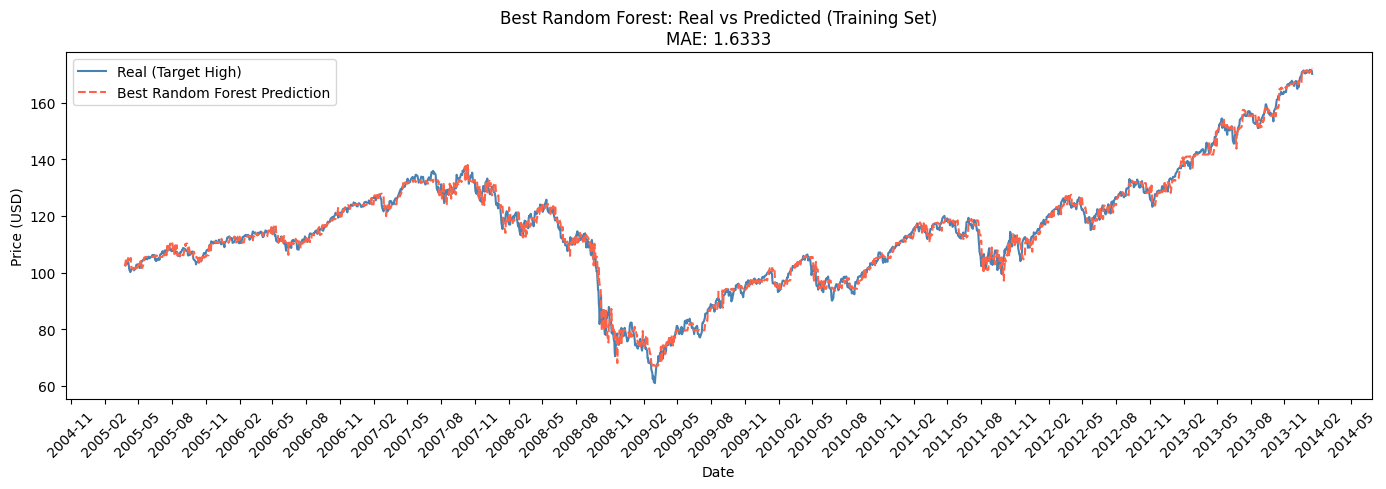

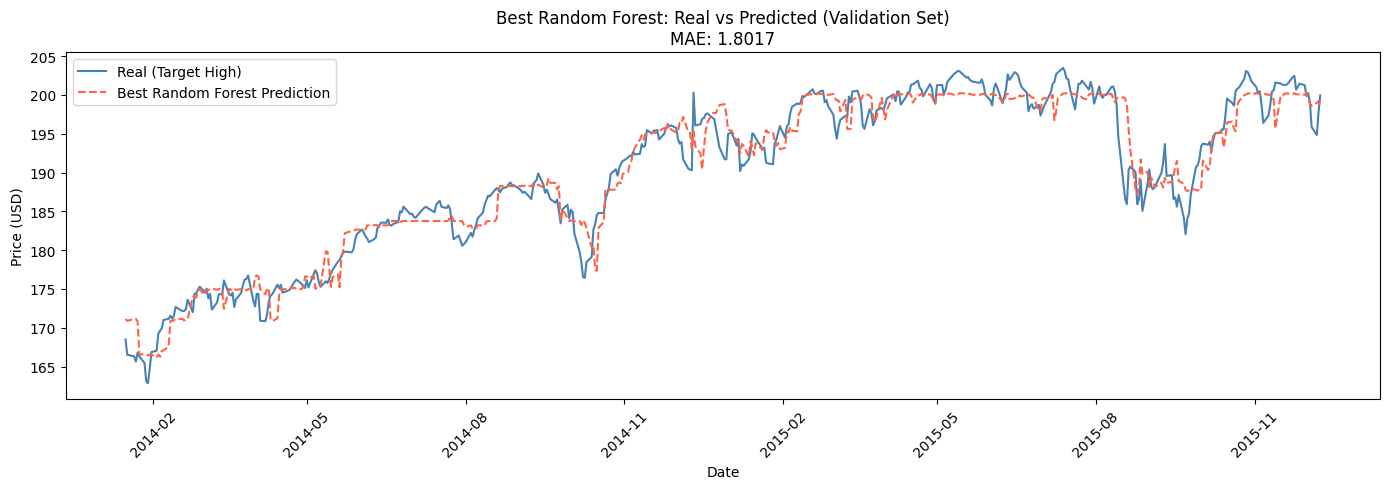

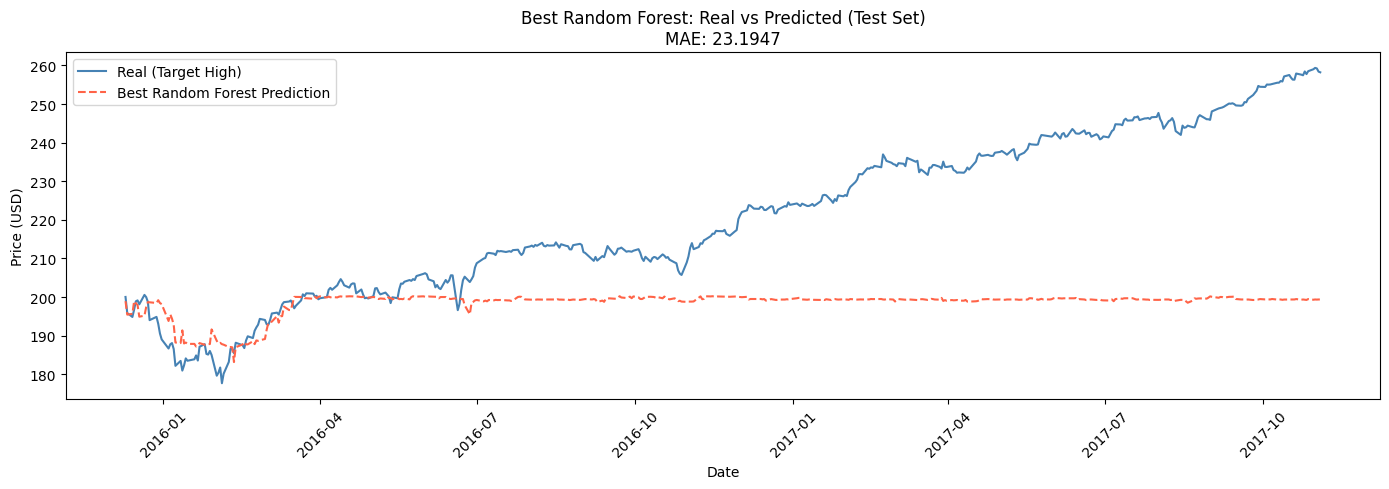

Best RF -> Train MAE: 1.6333
Best RF -> Val MAE:   1.8017
Best RF -> Test MAE:  23.1947


In [11]:
best_rf = grid_search.best_estimator_

print(f"best one: {grid_search.best_params_}\n")

mae_best_train = plot_predictions(best_rf, X_train_scaled, y_train, df, 'Training',   'Best Random Forest')
mae_best_val   = plot_predictions(best_rf, X_val_scaled,   y_val,   df, 'Validation', 'Best Random Forest')
mae_best_test  = plot_predictions(best_rf, X_test_scaled,  y_test,  df, 'Test',       'Best Random Forest')

print(f"Best RF -> Train MAE: {mae_best_train:.4f}")
print(f"Best RF -> Val MAE:   {mae_best_val:.4f}")
print(f"Best RF -> Test MAE:  {mae_best_test:.4f}")

In [12]:
#lo que pasa es el top de validation. no supera la el maximo de validation. 

### Model 2: GradientBoosting

In [13]:
# Define and train model
print("Training Gradient Boosting...")
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

Training Gradient Boosting...


,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [14]:
# Evaluation GBM
mae_gb_val = mean_absolute_error(y_val, gb_model.predict(X_val_scaled))
print(f"Gradient Boost -> Val MAE: {mae_gb_val:.4f}")

Gradient Boost -> Val MAE: 19.7642


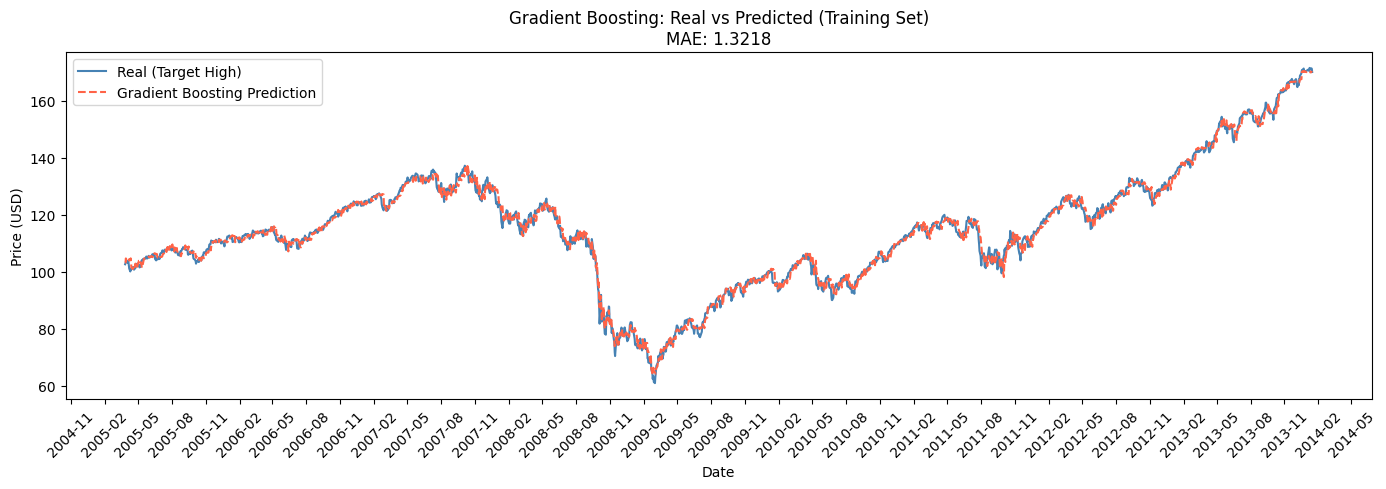

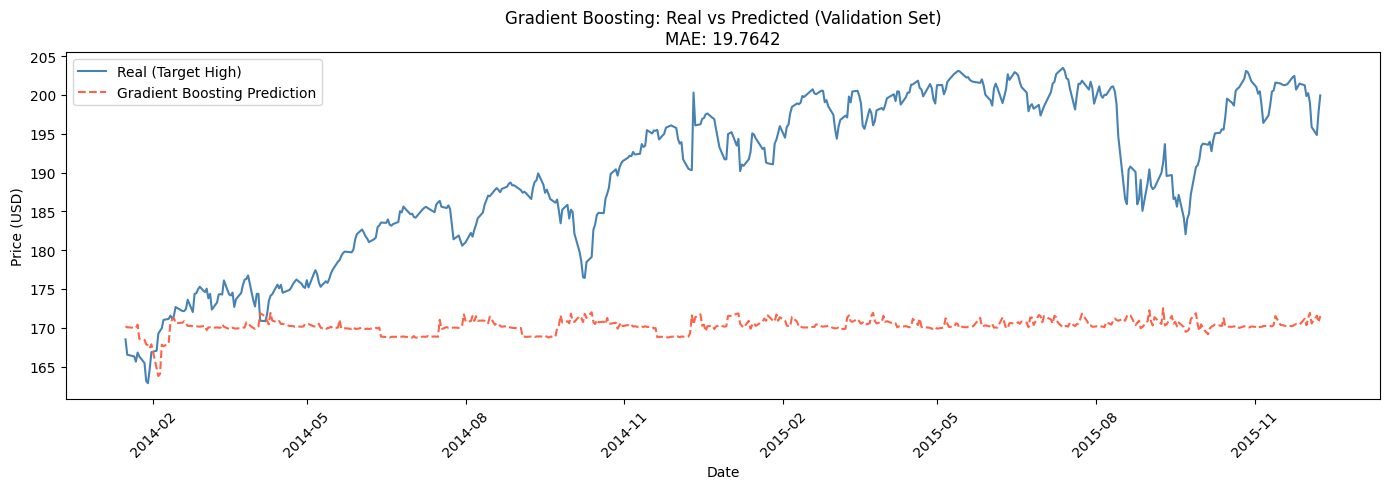

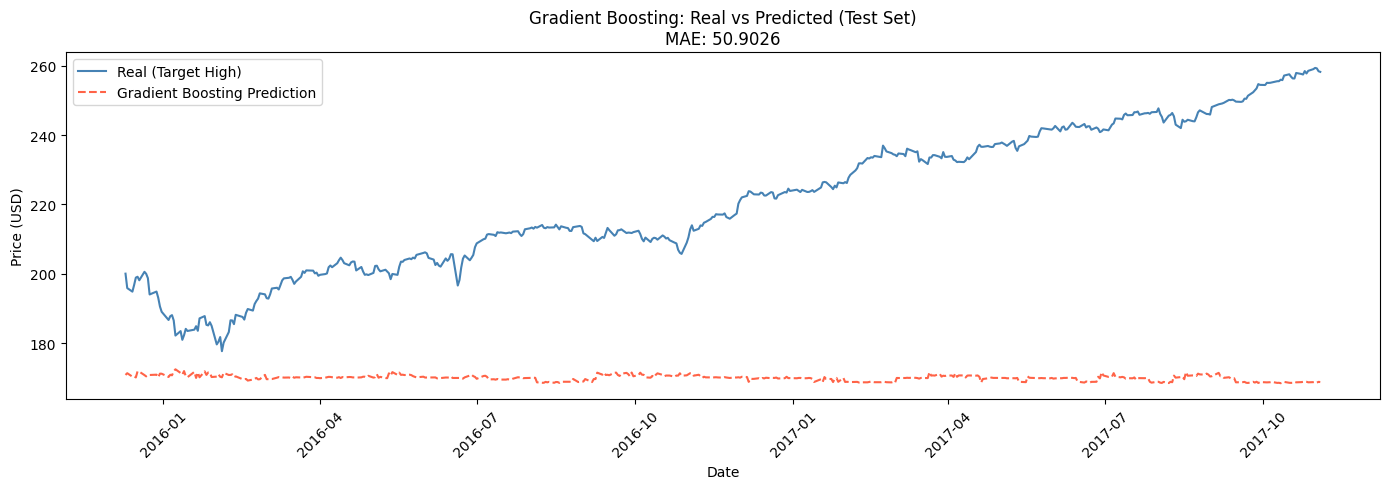

Gradient Boosting -> Train MAE: 1.3218
Gradient Boosting -> Val MAE:   19.7642
Gradient Boosting -> Test MAE:  50.9026


In [15]:
mae_gb_train = plot_predictions(gb_model, X_train_scaled, y_train, df, 'Training',   'Gradient Boosting')
mae_gb_val   = plot_predictions(gb_model, X_val_scaled,   y_val,   df, 'Validation', 'Gradient Boosting')
mae_gb_test  = plot_predictions(gb_model, X_test_scaled,  y_test,  df, 'Test',       'Gradient Boosting')

print(f"Gradient Boosting -> Train MAE: {mae_gb_train:.4f}")
print(f"Gradient Boosting -> Val MAE:   {mae_gb_val:.4f}")
print(f"Gradient Boosting -> Test MAE:  {mae_gb_test:.4f}")

In [16]:
param_grid_gb = {
    'n_estimators':     [100, 200],
    'learning_rate':    [0.01, 0.05, 0.1],
    'max_depth':        [3, 5, 7],
    'min_samples_leaf': [1, 5, 10],
}

# PredefinedSplit ensures the validation fold is always the same predefined split,
# preventing GridSearchCV from randomly shuffling the data across folds.
# This is critical for time series data, where future data must never be used to train the model.
# -1 = training samples, 0 = validation samples
split_index = [-1] * len(X_train_scaled) + [0] * len(X_val_scaled)
ps = PredefinedSplit(split_index)

X_trainval = np.concatenate([X_train_scaled, X_val_scaled])
y_trainval = np.concatenate([y_train, y_val])

grid_search_gb = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gb,
    cv=ps,
    scoring='neg_mean_absolute_error',
    verbose=1
)

grid_search_gb.fit(X_trainval, y_trainval)

print(f"Best params: {grid_search_gb.best_params_}")
print(f"Best Val MAE: {-grid_search_gb.best_score_:.4f}")

Fitting 1 folds for each of 54 candidates, totalling 54 fits
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 200}
Best Val MAE: 19.2517


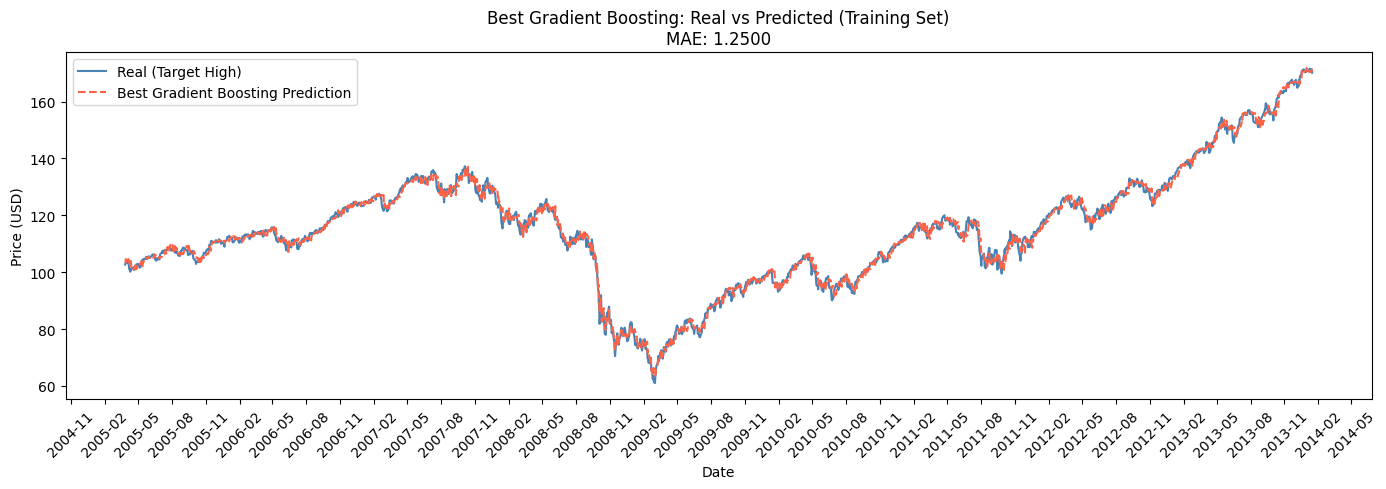

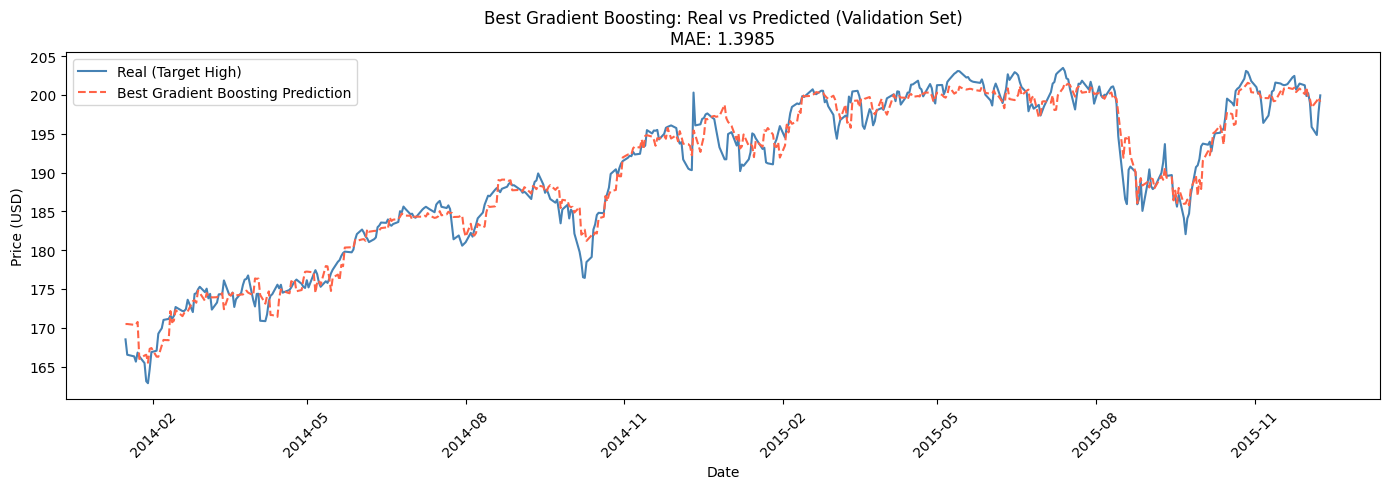

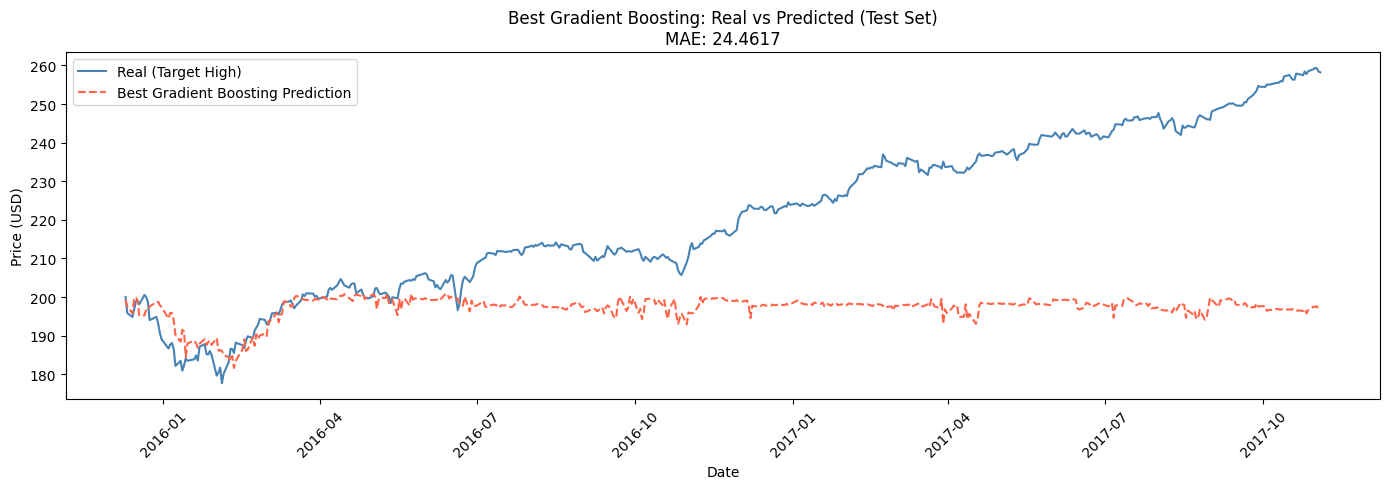

Best GBM -> Train MAE: 1.2500
Best GBM -> Val MAE:   1.3985
Best GBM -> Test MAE:  24.4617


In [17]:
best_gb = grid_search_gb.best_estimator_

mae_best_gb_train = plot_predictions(best_gb, X_train_scaled, y_train, df, 'Training',   'Best Gradient Boosting')
mae_best_gb_val   = plot_predictions(best_gb, X_val_scaled,   y_val,   df, 'Validation', 'Best Gradient Boosting')
mae_best_gb_test  = plot_predictions(best_gb, X_test_scaled,  y_test,  df, 'Test',       'Best Gradient Boosting')

print(f"Best GBM -> Train MAE: {mae_best_gb_train:.4f}")
print(f"Best GBM -> Val MAE:   {mae_best_gb_val:.4f}")
print(f"Best GBM -> Test MAE:  {mae_best_gb_test:.4f}")

### Shared Utilities 


In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Bridge variables: numpy copies for DL models (CNN+LSTM cells also use these names)
X_tr = X_train_scaled.copy()
X_vl = X_val_scaled.copy()
X_te = X_test_scaled.copy()
y_tr = y_train.values.copy()
y_vl = y_val.values.copy()
y_te = y_test.values.copy()

n_features = X_tr.shape[1]
print(f"Bridge variables ready: X_tr={X_tr.shape}, X_vl={X_vl.shape}, X_te={X_te.shape}")
print(f"Number of features: {n_features}")


def make_sequences(X, y, seq_len):
    """
    Create sliding-window sequences for LSTM input.

    Given X of shape (n_samples, n_features) and y of shape (n_samples,),
    returns:
        X_seq: (n_samples - seq_len, seq_len, n_features)
        y_seq: (n_samples - seq_len,)

    Each X_seq[i] contains rows X[i : i+seq_len] and the target is y[i+seq_len].
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i : i + seq_len])
        y_seq.append(y[i + seq_len])
    return np.array(X_seq), np.array(y_seq)


def plot_predictions_lstm(y_real, y_pred, date_index, set_name, model_name='LSTM'):
    """
    Plot real vs predicted values for LSTM models.
    Uses date_index (pandas Index) to look up dates from the global df.
    """
    mae = mean_absolute_error(y_real, y_pred)
    dates = pd.to_datetime(df.loc[date_index, 'Date'])

    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(dates.values, y_real, label='Real (Target High)', color='steelblue', linewidth=1.5)
    ax.plot(dates.values, y_pred, label=f'{model_name} Prediction', color='tomato', linewidth=1.5, linestyle='--')

    ax.set_title(f'{model_name}: Real vs Predicted ({set_name} Set)\nMAE: {mae:.4f}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price (USD)')
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return mae


print("Utilities defined: make_sequences(), plot_predictions_lstm()")

Bridge variables ready: X_tr=(2217, 8), X_vl=(479, 8), X_te=(480, 8)
Number of features: 8
Utilities defined: make_sequences(), plot_predictions_lstm()


### Model 3: LSTM


Approach A shapes: train=(2217, 8, 1), val=(479, 8, 1), test=(480, 8, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 8, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,761 (53.75 KB)

 Trainable params: 13,761 (53.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 102.9140 - val_loss: 150.8917
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 48.0524 - val_loss: 90.6514
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.0739 - val_loss: 76.2840
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 15.4644 - val_loss: 76.0812
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.4633 - val_loss: 76.1526
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 15.4615 - val_loss: 76.0624
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 15.4495 - val_loss: 76.0394
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 14.3292 - val_loss: 68.8192
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 12.2474 - val_loss: 62.0079
Epoch 10/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.3437 - val_loss: 48.2863
Epoch 11/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.1648 - val_loss: 40.2824
Epoch 12/100
70/70 ━━━━━━━━━━━━━

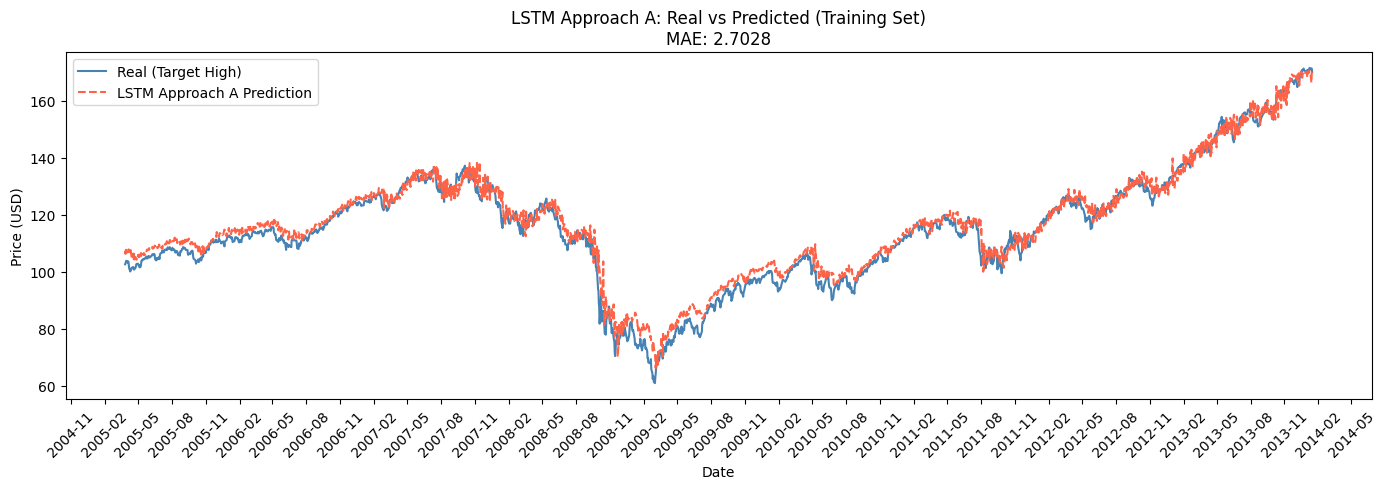

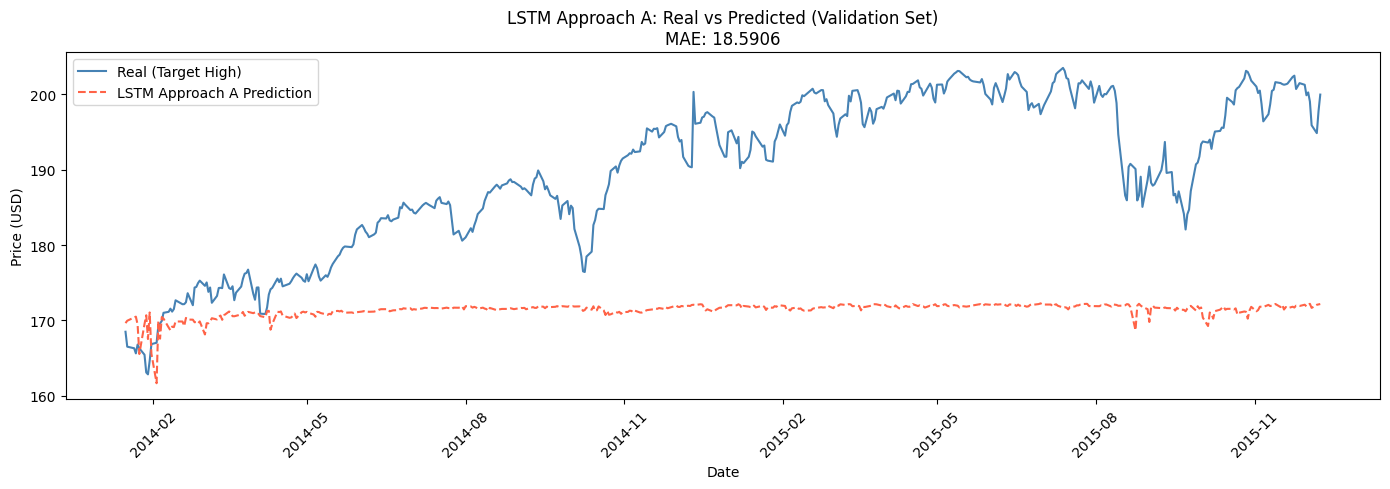

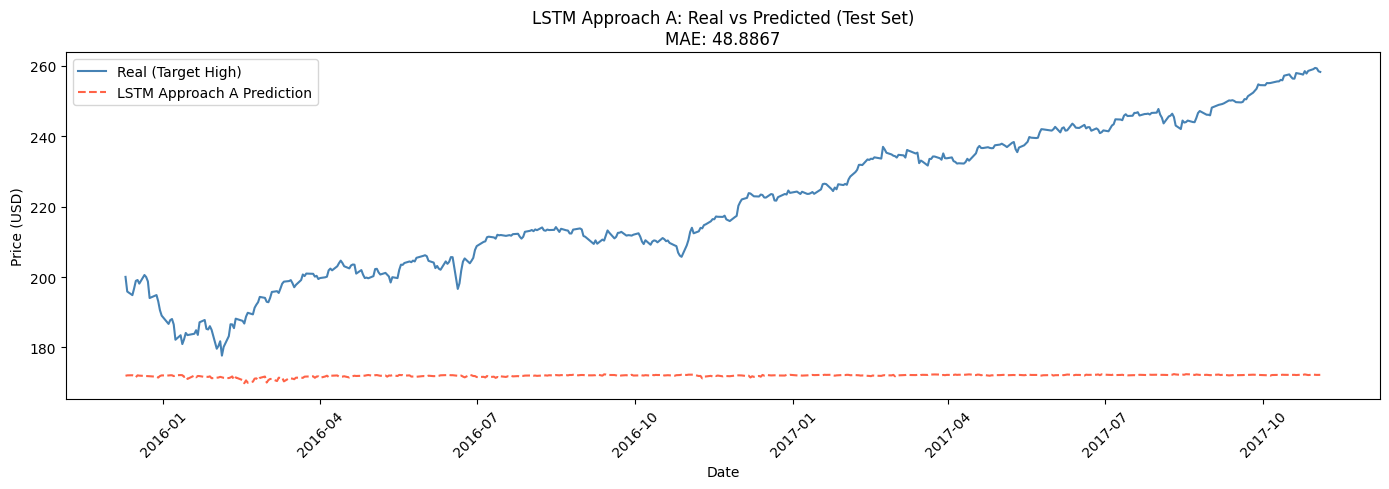

48.886692203267415

In [27]:

tf.random.set_seed(42)
np.random.seed(42)

X_train_A = X_tr.reshape(-1, n_features, 1)  # (2217, 8, 1)
X_val_A   = X_vl.reshape(-1, n_features, 1)  # (479, 8, 1)
X_test_A  = X_te.reshape(-1, n_features, 1)  # (480, 8, 1)

print(f"Approach A shapes: train={X_train_A.shape}, val={X_val_A.shape}, test={X_test_A.shape}")

# Architecture: Input -> LSTM(32) -> LSTM(32) -> Dense(32) -> Dense(1)
from tensorflow.keras.layers import Input
model_A = Sequential([
    Input(shape=(n_features, 1)),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=False),
    Dense(32),
    Dense(1)
])
model_A.compile(optimizer=Adam(), loss='mae')
model_A.summary()

# Train with EarlyStopping
history_A = model_A.fit(
    X_train_A, y_tr,
    validation_data=(X_val_A, y_vl),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)],
    verbose=1
)

# Evaluate
y_pred_train_A = model_A.predict(X_train_A, verbose=0).flatten()
y_pred_val_A   = model_A.predict(X_val_A, verbose=0).flatten()
y_pred_test_A  = model_A.predict(X_test_A, verbose=0).flatten()

mae_train_A = mean_absolute_error(y_tr, y_pred_train_A)
mae_val_A   = mean_absolute_error(y_vl, y_pred_val_A)
mae_test_A  = mean_absolute_error(y_te, y_pred_test_A)

print(f"\n--- Approach A: Features as timesteps ---")
print(f"Train MAE: {mae_train_A:.4f}")
print(f"Val   MAE: {mae_val_A:.4f}")
print(f"Test  MAE: {mae_test_A:.4f}")

# Plots
plot_predictions_lstm(y_tr, y_pred_train_A, X_train.index, 'Training', 'LSTM Approach A')
plot_predictions_lstm(y_vl, y_pred_val_A,   X_val.index,   'Validation', 'LSTM Approach A')
plot_predictions_lstm(y_te, y_pred_test_A,  X_test.index,  'Test', 'LSTM Approach A')

Approach B shapes:
  Train: X=(2197, 20, 8), y=(2197,)
  Val:   X=(479, 20, 8),   y=(479,)
  Test:  X=(480, 20, 8),  y=(480,)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 20, 32)              │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,657 (57.25 KB)

 Trainable params: 14,657 (57.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 103.6130 - val_loss: 157.5044
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 57.7598 - val_loss: 103.2403
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 18.4427 - val_loss: 75.3718
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 15.4626 - val_loss: 75.7224
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 12.8612 - val_loss: 67.1057
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 5.0062 - val_loss: 50.2591
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3.0691 - val_loss: 39.7750
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.3483 - val_loss: 33.4918
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.2035 - val_loss: 31.2035
Epoch 10/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.9665 - val_loss: 29.0288
Epoch 11/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.8528 - val_loss: 26.7683
Epoch 12/100
69/69 ━━━━━━━━━━━━━━

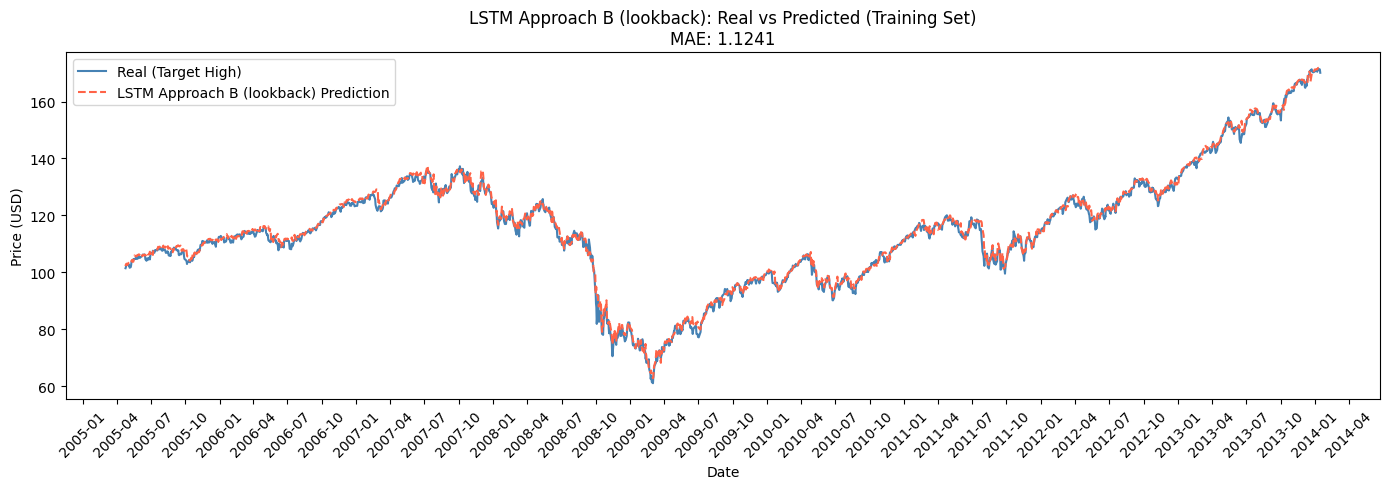

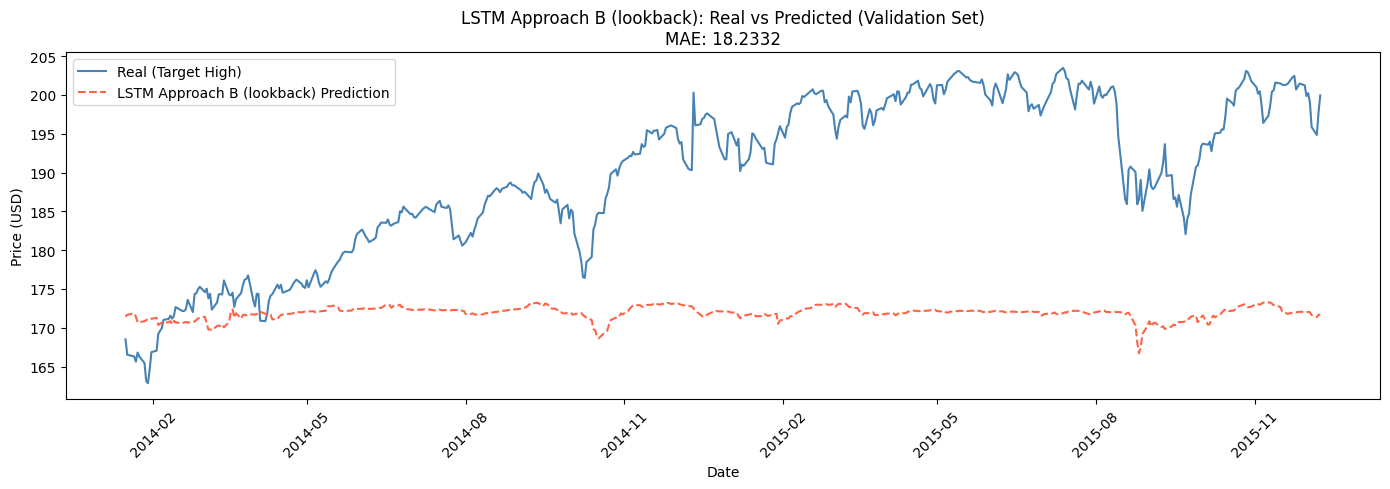

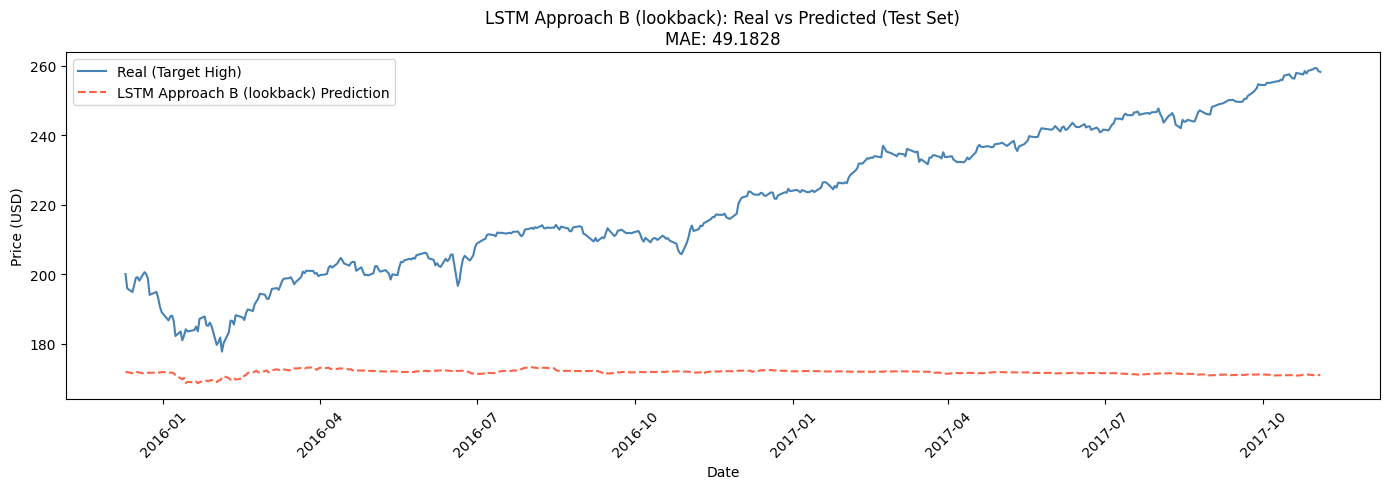


--- Comparison ---
Approach A (features as timesteps)    -> Val MAE: 18.5906
Approach B (lookback window=20)  -> Val MAE: 18.2332


In [28]:

tf.random.set_seed(42)
np.random.seed(42)

SEQ_LEN = 20  # lookback window: 20 days of history

# Build sequences: concatenate train+val first, then split respecting temporal order
X_tv = np.concatenate([X_tr, X_vl])
y_tv = np.concatenate([y_tr, y_vl])
X_seq_tv, y_seq_tv = make_sequences(X_tv, y_tv, SEQ_LEN)

# Split point: training samples end at len(X_tr) 
split_B = len(X_tr) - SEQ_LEN
X_seq_train_B = X_seq_tv[:split_B]
y_seq_train_B = y_seq_tv[:split_B]
X_seq_val_B   = X_seq_tv[split_B:]
y_seq_val_B   = y_seq_tv[split_B:]

# Test sequences: use val tail as context
X_vt = np.concatenate([X_vl, X_te])
y_vt = np.concatenate([y_vl, y_te])
X_seq_vt, y_seq_vt = make_sequences(X_vt, y_vt, SEQ_LEN)
split_test_B = len(X_vl) - SEQ_LEN
X_seq_test_B = X_seq_vt[split_test_B:]
y_seq_test_B = y_seq_vt[split_test_B:]

print(f"Approach B shapes:")
print(f"  Train: X={X_seq_train_B.shape}, y={y_seq_train_B.shape}")
print(f"  Val:   X={X_seq_val_B.shape},   y={y_seq_val_B.shape}")
print(f"  Test:  X={X_seq_test_B.shape},  y={y_seq_test_B.shape}")

# Architecture: Input -> LSTM(32) -> LSTM(32) -> Dense(32) -> Dense(1)
model_B = Sequential([
    Input(shape=(SEQ_LEN, n_features)),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=False),
    Dense(32),
    Dense(1)
])
model_B.compile(optimizer=Adam(), loss='mae')
model_B.summary()

# Train with EarlyStopping
history_B = model_B.fit(
    X_seq_train_B, y_seq_train_B,
    validation_data=(X_seq_val_B, y_seq_val_B),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)],
    verbose=1
)

# Evaluate
y_pred_train_B = model_B.predict(X_seq_train_B, verbose=0).flatten()
y_pred_val_B   = model_B.predict(X_seq_val_B, verbose=0).flatten()
y_pred_test_B  = model_B.predict(X_seq_test_B, verbose=0).flatten()

mae_train_B = mean_absolute_error(y_seq_train_B, y_pred_train_B)
mae_val_B   = mean_absolute_error(y_seq_val_B, y_pred_val_B)
mae_test_B  = mean_absolute_error(y_seq_test_B, y_pred_test_B)

print(f"\n--- Approach B: Lookback window (lookback={SEQ_LEN}) ---")
print(f"Train MAE: {mae_train_B:.4f}")
print(f"Val   MAE: {mae_val_B:.4f}")
print(f"Test  MAE: {mae_test_B:.4f}")

# Plots — date alignment

train_date_idx_B = X_train.index[SEQ_LEN:]  # skip first SEQ_LEN rows
val_date_idx_B   = X_val.index
test_date_idx_B  = X_test.index

plot_predictions_lstm(y_seq_train_B, y_pred_train_B, train_date_idx_B, 'Training', 'LSTM Approach B (lookback)')
plot_predictions_lstm(y_seq_val_B,   y_pred_val_B,   val_date_idx_B,   'Validation', 'LSTM Approach B (lookback)')
plot_predictions_lstm(y_seq_test_B,  y_pred_test_B,  test_date_idx_B,  'Test', 'LSTM Approach B (lookback)')

print(f"\n--- Comparison ---")
print(f"Approach A (features as timeForsteps)    -> Val MAE: {mae_val_A:.4f}")
print(f"Approach B (lookback window={SEQ_LEN})  -> Val MAE: {mae_val_B:.4f}")

#### Grid Search LSTM 

In [29]:
from itertools import product

tf.random.set_seed(42)
np.random.seed(42)

# Hyperparameter grid
param_grid_lstm = {
    'units':         [32, 64, 128],
    'learning_rate': [0.01, 0.001],
    'batch_size':    [32, 64],
    'seq_len':       [20, 30],
}

# Generate all combinations
keys = list(param_grid_lstm.keys())
values = list(param_grid_lstm.values())
all_configs = [dict(zip(keys, combo)) for combo in product(*values)]
total_configs = len(all_configs)
print(f"Total LSTM configurations to evaluate: {total_configs}")

# Grid search loop
best_val_mae_lstm = np.inf
best_params_lstm  = None
best_model_lstm   = None
best_seq_len_lstm = None
grid_results_lstm = []

n_train_lstm = len(X_tr)

for idx, params in enumerate(all_configs):
    units         = params['units']
    learning_rate = params['learning_rate']
    batch_size    = params['batch_size']
    seq_len       = params['seq_len']

    # Build sequences with temporal split (equivalent to PredefinedSplit)
    # Training data comes first, validation data comes after — no shuffling
    X_tv_gs = np.concatenate([X_tr, X_vl])
    y_tv_gs = np.concatenate([y_tr, y_vl])
    X_seq_tv_gs, y_seq_tv_gs = make_sequences(X_tv_gs, y_tv_gs, seq_len)

    split_gs = n_train_lstm - seq_len
    X_seq_train_gs = X_seq_tv_gs[:split_gs]
    y_seq_train_gs = y_seq_tv_gs[:split_gs]
    X_seq_val_gs   = X_seq_tv_gs[split_gs:]
    y_seq_val_gs   = y_seq_tv_gs[split_gs:]

    # Clear previous model from memory
    tf.keras.backend.clear_session()

    # Build LSTM: Input -> LSTM(units) -> LSTM(units) -> Dense(units) -> Dense(1)
    model_gs = Sequential([
        Input(shape=(seq_len, n_features)),
        LSTM(units, return_sequences=True),
        LSTM(units, return_sequences=False),
        Dense(units),
        Dense(1)
    ])
    model_gs.compile(optimizer=Adam(learning_rate=learning_rate), loss='mae')

    # Train with EarlyStopping
    model_gs.fit(
        X_seq_train_gs, y_seq_train_gs,
        validation_data=(X_seq_val_gs, y_seq_val_gs),
        epochs=100,
        batch_size=batch_size,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10,
                                 restore_best_weights=True, verbose=0)],
        verbose=0
    )

    # Evaluate on validation
    y_pred_val_gs = model_gs.predict(X_seq_val_gs, verbose=0).flatten()
    val_mae_gs = mean_absolute_error(y_seq_val_gs, y_pred_val_gs)
    grid_results_lstm.append({**params, 'val_mae': val_mae_gs})

    if val_mae_gs < best_val_mae_lstm:
        best_val_mae_lstm = val_mae_gs
        best_params_lstm  = params.copy()
        best_model_lstm   = model_gs
        best_seq_len_lstm = seq_len

    print(f"[{idx+1:2d}/{total_configs}] units={units}, lr={learning_rate}, "
          f"bs={batch_size}, seq={seq_len}  ->  Val MAE: {val_mae_gs:.4f}")

print(f"\n>>> Best LSTM config : {best_params_lstm}")
print(f">>> Best LSTM Val MAE: {best_val_mae_lstm:.4f}")

# Show all results sorted
df_lstm_results = pd.DataFrame(grid_results_lstm).sort_values('val_mae')
print("\nAll configurations (sorted by Val MAE):")
print(df_lstm_results.to_string(index=False))

Total LSTM configurations to evaluate: 24
[ 1/24] units=32, lr=0.01, bs=32, seq=20  ->  Val MAE: 74.4831
[ 2/24] units=32, lr=0.01, bs=32, seq=30  ->  Val MAE: 17.9952
[ 3/24] units=32, lr=0.01, bs=64, seq=20  ->  Val MAE: 69.3160
[ 4/24] units=32, lr=0.01, bs=64, seq=30  ->  Val MAE: 71.4561
[ 5/24] units=32, lr=0.001, bs=32, seq=20  ->  Val MAE: 18.9328


KeyboardInterrupt: 

Best LSTM config: {'units': 128, 'learning_rate': 0.001, 'batch_size': 32, 'seq_len': 30}
Best LSTM -> Train MAE: 1.6194
Best LSTM -> Val   MAE: 9.9511
Best LSTM -> Test  MAE: 38.4109


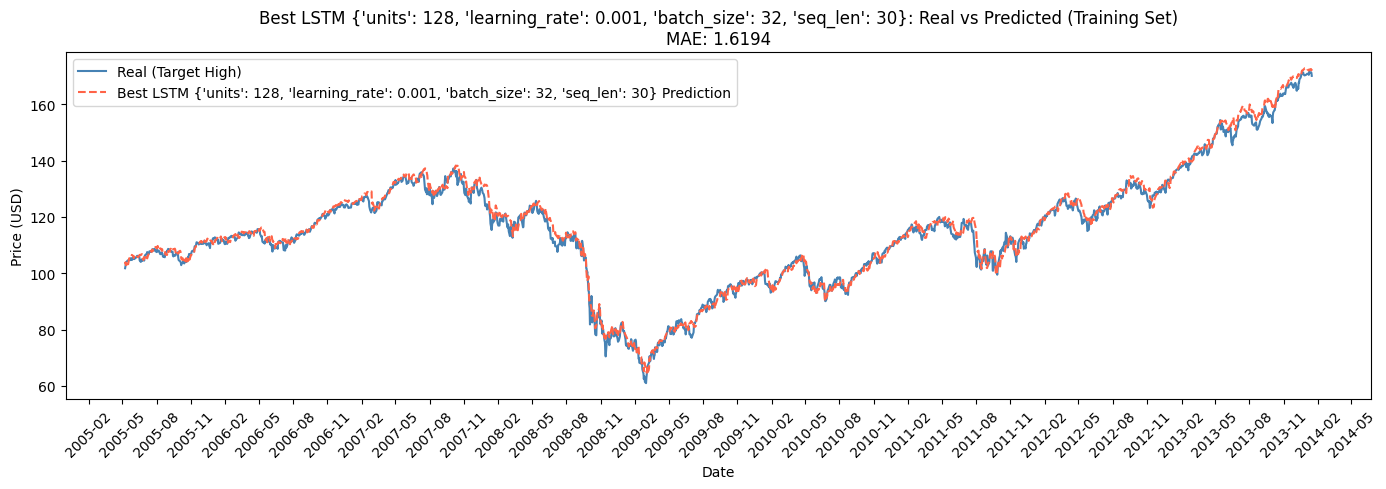

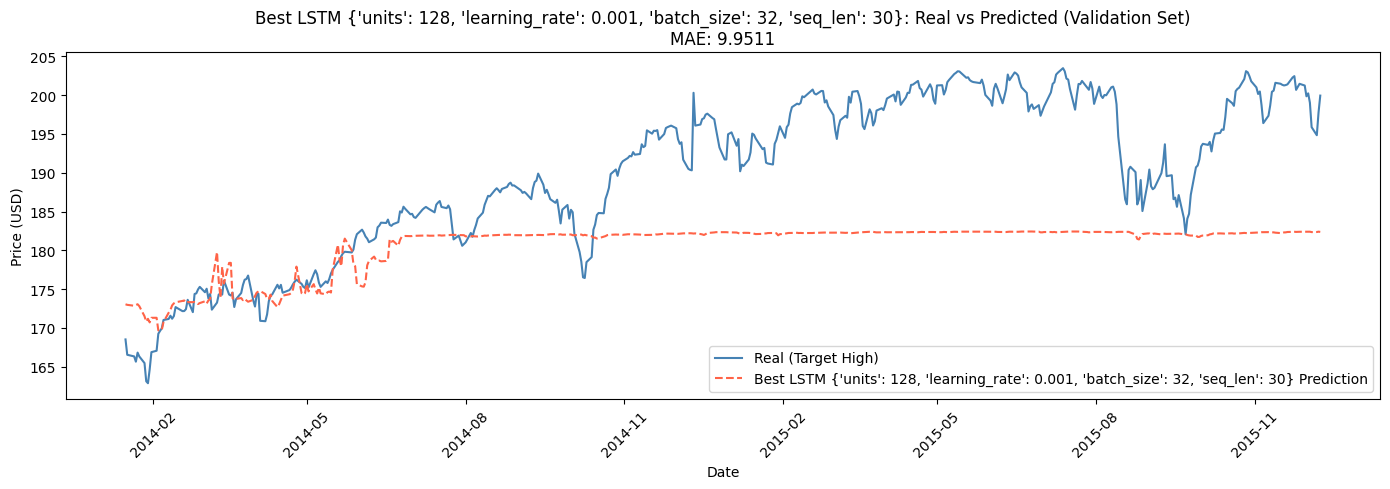

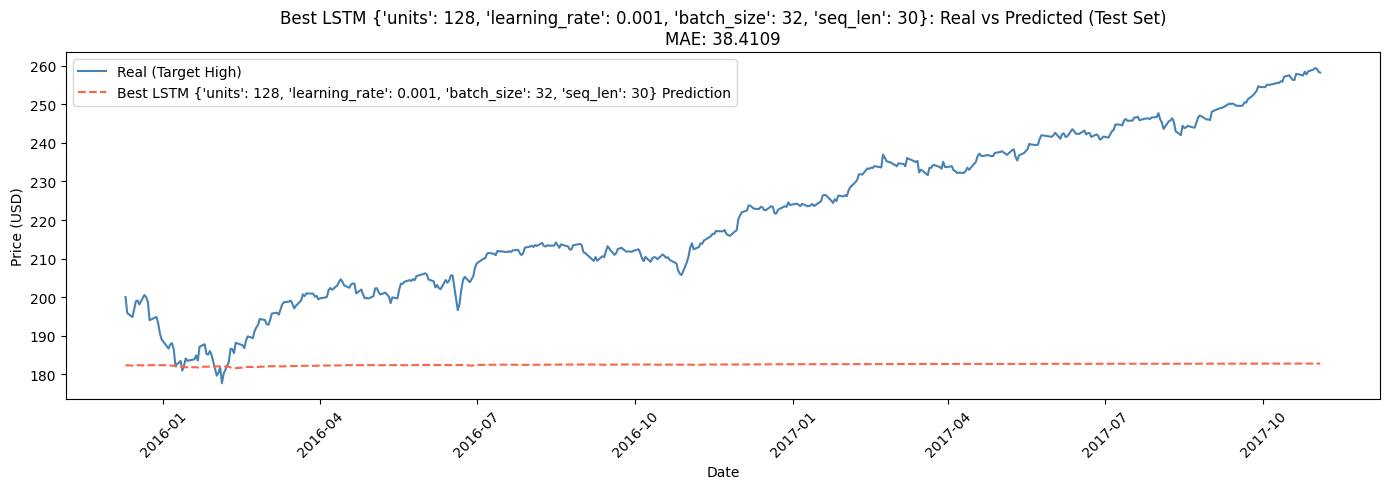

38.410890976969405

In [25]:
# ── Final evaluation of the best LSTM model from Grid Search ─────────────
seq_len = best_seq_len_lstm

# Rebuild train/val/test sequences with the best seq_len
X_tv_best = np.concatenate([X_tr, X_vl])
y_tv_best = np.concatenate([y_tr, y_vl])
X_seq_tv_best, y_seq_tv_best = make_sequences(X_tv_best, y_tv_best, seq_len)
split_best = len(X_tr) - seq_len
X_seq_train_best_lstm = X_seq_tv_best[:split_best]
y_seq_train_best_lstm = y_seq_tv_best[:split_best]
X_seq_val_best_lstm   = X_seq_tv_best[split_best:]
y_seq_val_best_lstm   = y_seq_tv_best[split_best:]

# Test sequences
X_vt_best = np.concatenate([X_vl, X_te])
y_vt_best = np.concatenate([y_vl, y_te])
X_seq_vt_best, y_seq_vt_best = make_sequences(X_vt_best, y_vt_best, seq_len)
split_test_best = len(X_vl) - seq_len
X_seq_test_best_lstm = X_seq_vt_best[split_test_best:]
y_seq_test_best_lstm = y_seq_vt_best[split_test_best:]

# Predictions
y_pred_train_best = best_model_lstm.predict(X_seq_train_best_lstm, verbose=0).flatten()
y_pred_val_best   = best_model_lstm.predict(X_seq_val_best_lstm, verbose=0).flatten()
y_pred_test_best  = best_model_lstm.predict(X_seq_test_best_lstm, verbose=0).flatten()

mae_train_best = mean_absolute_error(y_seq_train_best_lstm, y_pred_train_best)
mae_val_best   = mean_absolute_error(y_seq_val_best_lstm, y_pred_val_best)
mae_test_best  = mean_absolute_error(y_seq_test_best_lstm, y_pred_test_best)

print(f"Best LSTM config: {best_params_lstm}")
print(f"Best LSTM -> Train MAE: {mae_train_best:.4f}")
print(f"Best LSTM -> Val   MAE: {mae_val_best:.4f}")
print(f"Best LSTM -> Test  MAE: {mae_test_best:.4f}")

# Date alignment
train_date_idx_best = X_train.index[seq_len:]
val_date_idx_best   = X_val.index
test_date_idx_best  = X_test.index

# Plots
label_best = f'Best LSTM {best_params_lstm}'
plot_predictions_lstm(y_seq_train_best_lstm, y_pred_train_best, train_date_idx_best, 'Training', label_best)
plot_predictions_lstm(y_seq_val_best_lstm,   y_pred_val_best,   val_date_idx_best,   'Validation', label_best)
plot_predictions_lstm(y_seq_test_best_lstm,  y_pred_test_best,  test_date_idx_best,  'Test', label_best)

## Online Learning

In [33]:
# Create Pipeline: Feature Extraction -> Model
# We use HoeffdingAdaptiveTreeRegressor
river_model = compose.Pipeline(
    OnlineSPYFeatures(),   # Custom transformer to extract features from the raw data stream
    preprocessing.StandardScaler(),  # Scales the data (standarization) to avoid inestability
    tree.HoeffdingAdaptiveTreeRegressor(
        grace_period=50,       # How often to check for splits
        model_selector_decay=0.9
    )
)

# Metric for Validation
metric_val  = metrics.MAE()
metric_test = metrics.MAE()

In [34]:
# We iterate through the entire dataset sequentially
print("Processing stream row by row...")
records_val  = []
records_test = []
for i, (index, row) in enumerate(df.iterrows()):
    
    # Prepare input (x) and target (y)
    x = row[['Open', 'High', 'Low', 'Close', 'Volume']].to_dict()
    y = row['Target_High']
    
    # 1. PREDICT (Test-then-Train approach)
    # We make a prediction before the model learns from this specific example
    y_pred = river_model.predict_one(x)   # predict_one takes the x, transforms it with OnlineSPYFeatures and StandardScaler, and predicts with the model
    
    # 2. UPDATE METRICS
    # We only update the metric if we are currently in the Validation segment (would be equivalent for test)
    if index in X_val.index:
        metric_val.update(y, y_pred)
        records_val.append({'date': row['Date'], 'y_real': y, 'y_pred': y_pred})

    if index in X_test.index:
        metric_test.update(y, y_pred)
        records_test.append({'date': row['Date'], 'y_real': y, 'y_pred': y_pred})
    # 3. LEARN
    # The model updates its internal state with the new truth
    river_model.learn_one(x, y)

Processing stream row by row...


In [35]:
print(f"Online HoeffdingAdaptiveTreeRegressor -> Val MAE: {metric_val.get():.4f}")
print(f"Online HoeffdingAdaptiveTreeRegressor -> Val MAE: {metric_test.get():.4f}")

Online HoeffdingAdaptiveTreeRegressor -> Val MAE: 4.0260
Online HoeffdingAdaptiveTreeRegressor -> Val MAE: 3.1520


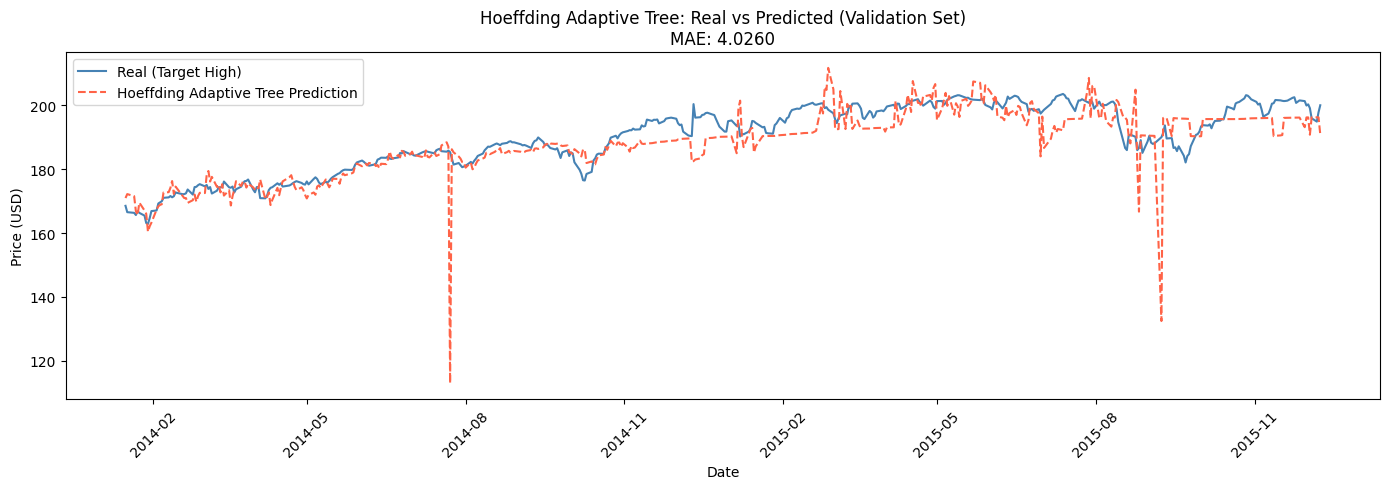

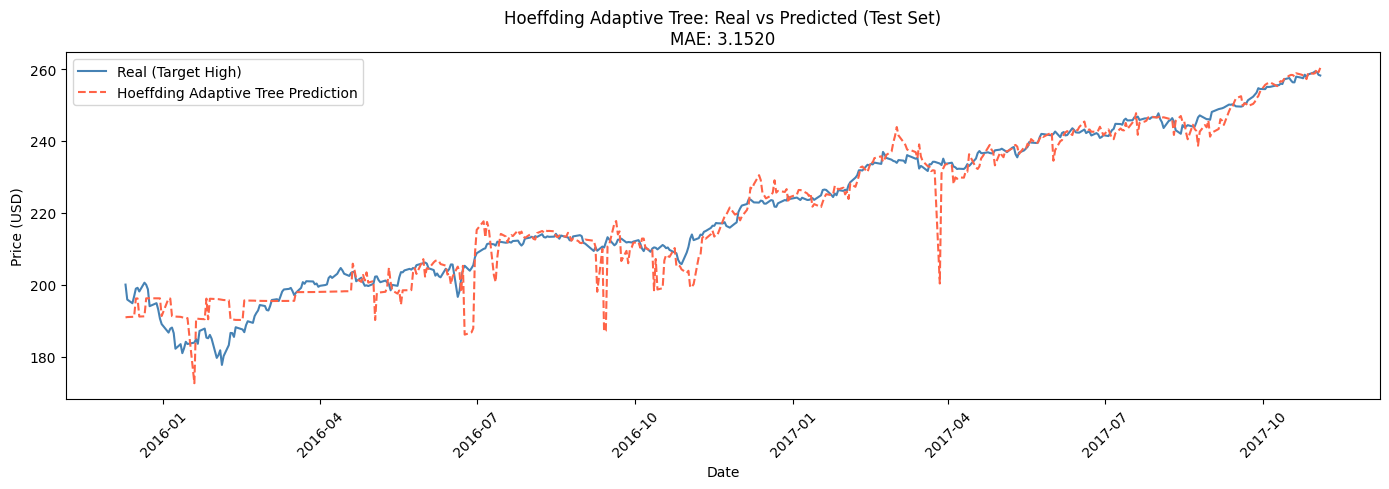

In [36]:
def plot_predictions_online(records, set_name, model_name='Online Model'):
    df_plot = pd.DataFrame(records)
    df_plot['date'] = pd.to_datetime(df_plot['date'])
    mae = mean_absolute_error(df_plot['y_real'], df_plot['y_pred'])

    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(df_plot['date'], df_plot['y_real'], label='Real (Target High)', color='steelblue', linewidth=1.5)
    ax.plot(df_plot['date'], df_plot['y_pred'], label=f'{model_name} Prediction', color='tomato', linewidth=1.5, linestyle='--')

    ax.set_title(f'{model_name}: Real vs Predicted ({set_name} Set)\nMAE: {mae:.4f}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price (USD)')
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return mae


mae_online_val  = plot_predictions_online(records_val,  'Validation', 'Hoeffding Adaptive Tree')
mae_online_test = plot_predictions_online(records_test, 'Test',       'Hoeffding Adaptive Tree')
